In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from xgboost import plot_importance, XGBClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from time import time
import umap
import seaborn as sns

In [2]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [ ]:
X_flat = np.array(X).reshape((2062, 64*64))

In [ ]:
Ydf = DataFrame(data=Y, columns=[9-x for x in range(10)])
Ydf = Ydf[[x for x in range(10)]]
Ydf['class']='C' + (Ydf[range(10)].idxmax(axis=1)).astype('str')
Ydf[['class']]
Y2 = Ydf[['class']].to_numpy()

In [ ]:
Y2.shape

In [ ]:
Y2 = Y2.reshape(Y2.shape[0])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_flat, Y2, test_size=0.3, random_state=42)

## XGBoost

In [ ]:
model = XGBClassifier()

In [ ]:
t_0 = time()
model.fit(X_train,y_train)
Duration_XGB = time() - t_0

In [ ]:
y_pred = model.predict(X_valid)

In [ ]:
conf_mat = confusion_matrix(y_valid, y_pred)

In [ ]:
#display(DataFrame(data=conf_mat))
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()

In [ ]:
accuracy = accuracy_score(y_valid, y_pred)
print(accuracy)

## PCA

In [ ]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
d

In [ ]:
pca_dims = PCA(n_components=d)
X_pca_train = pca_dims.fit_transform(X_train)
X_pca_valid = pca_dims.transform(X_valid)

## XGBoost over PCA

In [ ]:
model_pca = XGBClassifier()
t_0 = time()
model_pca.fit(X_pca_train,y_train)
Duration_XGB_PCA = time() - t_0

In [ ]:
y_pca_pred = model_pca.predict(X_pca_valid)

In [ ]:
print(accuracy_score(y_valid, y_pca_pred))

In [ ]:
conf_mat = confusion_matrix(y_valid, y_pca_pred)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()

## SVM

In [ ]:
model_svm = svm.SVC(gamma='scale')
t_0 = time()
model_svm.fit(X_train,y_train)
Duration_SVM = time() - t_0

In [ ]:
y_pred_svm = model_svm.predict(X_valid)

In [ ]:
conf_mat = confusion_matrix(y_valid, y_pred_svm)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print(accuracy_score(y_valid, y_pred_svm))

## SVM over PCA

In [ ]:
model_svm_pca = svm.SVC(gamma='scale')
t_0 = time()
model_svm_pca.fit(X_pca_train,y_train)
Duration_SVM_PCA = time() - t_0

In [ ]:
y_pred_svm_pca = model_svm_pca.predict(X_pca_valid)
conf_mat = confusion_matrix(y_valid, y_pred_svm_pca)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print(accuracy_score(y_valid, y_pred_svm_pca))

In [ ]:
print('XGBoost Computation time: ' + str(Duration_XGB))
print('XGBoost over PCA Computation time: ' + str(Duration_XGB_PCA))
print('SVM Computation time: ' + str(Duration_SVM))
print('SVM over PCA Computation time: ' + str(Duration_SVM_PCA))

### Modèle de convolution avec Keras

In [77]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

In [78]:
X_train = X_train.reshape((1443, 64, 64, -1))
X_valid = X_valid.reshape((619, 64, 64, -1))
print(X_train.shape)
print(y_train.shape)

(1443, 64, 64, 1)
(1443, 10)


In [79]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

# Normalize the images.
#X_train = (X_train / 255) - 0.5
#X_valid = (X_valid / 255) - 0.5

# Reshape the images.
#X_train = np.expand_dims(X_train, axis=3)
#X_valid = np.expand_dims(X_valid, axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

num_filters2 = 12
filter_size2 = 3
pool_size2 = 2

num_filters3 = 12
filter_size3 = 3
pool_size3 = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(64, 64, 1), activation='softplus'),
  MaxPooling2D(pool_size=pool_size),
  Conv2D(num_filters2, filter_size2, input_shape=(64, 64, 1), activation='softplus'),
  MaxPooling2D(pool_size=pool_size2),
  Conv2D(num_filters3, filter_size3, input_shape=(64, 64, 1), activation='softplus'),
  MaxPooling2D(pool_size=pool_size3),
  Flatten(),
  Dense(10, activation='softmax'),
])

# Compile the model.
learning_rate = 0.01
model.compile(
  'RMSprop',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
  #optimizer=SGD(lr=learning_rate)
)

#callbacks = [EarlyStopping(monitor='val_accuracy', patience=5)]

# Train the model.
history = model.fit(
  X_train,
  y_train,
  epochs=100,
  #callbacks=callbacks,
  validation_data=(X_valid, y_valid),
)

Train on 1443 samples, validate on 619 samples
Epoch 1/100
1443/1443 [==============================] - 2s 2ms/step - loss: 2.3608 - accuracy: 0.0894 - val_loss: 2.3824 - val_accuracy: 0.0969
Epoch 2/100
1443/1443 [==============================] - 2s 1ms/step - loss: 2.3219 - accuracy: 0.0894 - val_loss: 2.3579 - val_accuracy: 0.1276
Epoch 3/100
1443/1443 [==============================] - 2s 1ms/step - loss: 2.3105 - accuracy: 0.0998 - val_loss: 2.3171 - val_accuracy: 0.0889
Epoch 4/100
1443/1443 [==============================] - 2s 1ms/step - loss: 2.3048 - accuracy: 0.1081 - val_loss: 2.3028 - val_accuracy: 0.1244
Epoch 5/100
1443/1443 [==============================] - 2s 1ms/step - loss: 2.3033 - accuracy: 0.0998 - val_loss: 2.3041 - val_accuracy: 0.1486
Epoch 6/100
1443/1443 [==============================] - 2s 1ms/step - loss: 2.3023 - accuracy: 0.1033 - val_loss: 2.3077 - val_accuracy: 0.0840
Epoch 7/100
1443/1443 [==============================] - 2s 1ms/step - loss: 2.2953

Epoch 57/100
1443/1443 [==============================] - 2s 1ms/step - loss: 0.0617 - accuracy: 0.9834 - val_loss: 0.5419 - val_accuracy: 0.8788
Epoch 58/100
1443/1443 [==============================] - 2s 1ms/step - loss: 0.0605 - accuracy: 0.9834 - val_loss: 0.4477 - val_accuracy: 0.9015
Epoch 59/100
1443/1443 [==============================] - 2s 1ms/step - loss: 0.0621 - accuracy: 0.9757 - val_loss: 0.4136 - val_accuracy: 0.9031
Epoch 60/100
1443/1443 [==============================] - 2s 1ms/step - loss: 0.0504 - accuracy: 0.9834 - val_loss: 0.4858 - val_accuracy: 0.8837
Epoch 61/100
1443/1443 [==============================] - 2s 1ms/step - loss: 0.0514 - accuracy: 0.9806 - val_loss: 0.4362 - val_accuracy: 0.8901
Epoch 62/100
1443/1443 [==============================] - 2s 1ms/step - loss: 0.0436 - accuracy: 0.9827 - val_loss: 0.5686 - val_accuracy: 0.9031
Epoch 63/100
1443/1443 [==============================] - 2s 1ms/step - loss: 0.0444 - accuracy: 0.9841 - val_loss: 0.4371 -

In [80]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 62, 62, 8)         80        
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 29, 29, 12)        876       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 12, 12, 12)        1308      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 6, 6, 12)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 432)             

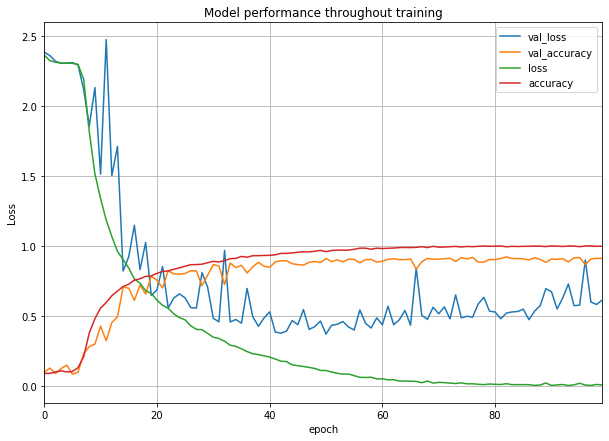

In [81]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [82]:
Y_predict = model.predict_classes(X_valid)

In [83]:
Y_predict

array([3, 9, 3, 9, 0, 5, 8, 2, 5, 9, 4, 9, 7, 1, 3, 3, 0, 5, 0, 7, 0, 8,
       3, 6, 9, 2, 7, 3, 5, 9, 8, 5, 4, 6, 4, 6, 3, 1, 9, 2, 7, 8, 3, 1,
       1, 6, 0, 7, 8, 9, 1, 9, 2, 2, 1, 0, 6, 8, 2, 8, 2, 7, 2, 7, 5, 9,
       2, 3, 6, 4, 1, 1, 2, 7, 4, 9, 9, 4, 3, 8, 2, 9, 2, 0, 6, 0, 0, 4,
       1, 2, 5, 4, 7, 4, 7, 4, 2, 2, 8, 7, 2, 0, 9, 0, 2, 1, 7, 8, 8, 7,
       5, 8, 3, 3, 2, 6, 6, 1, 2, 5, 6, 0, 1, 5, 2, 2, 6, 5, 1, 0, 3, 1,
       9, 9, 8, 3, 8, 9, 2, 2, 2, 6, 2, 6, 6, 1, 5, 2, 5, 4, 9, 2, 1, 2,
       6, 2, 6, 6, 1, 1, 7, 2, 9, 8, 6, 2, 4, 7, 6, 9, 3, 7, 2, 9, 1, 6,
       7, 3, 0, 6, 1, 7, 4, 8, 4, 3, 5, 2, 4, 2, 8, 6, 8, 3, 2, 0, 8, 8,
       8, 5, 4, 7, 0, 2, 2, 4, 2, 5, 2, 8, 9, 0, 2, 2, 5, 3, 4, 3, 5, 0,
       6, 4, 6, 1, 7, 5, 4, 1, 9, 5, 8, 4, 7, 6, 3, 1, 5, 4, 6, 4, 9, 3,
       1, 0, 9, 0, 1, 2, 3, 9, 5, 4, 2, 0, 0, 8, 2, 5, 9, 2, 4, 7, 9, 8,
       3, 7, 3, 7, 7, 1, 1, 1, 8, 9, 5, 7, 7, 3, 1, 7, 5, 3, 6, 9, 1, 9,
       2, 9, 8, 3, 0, 7, 0, 8, 0, 6, 5, 2, 1, 0, 0,

In [84]:
y_valid_flat = [list(y).index(1) for y in y_valid]
y_valid_flat

[6,
 9,
 3,
 9,
 0,
 5,
 8,
 2,
 5,
 9,
 4,
 9,
 7,
 1,
 3,
 3,
 0,
 5,
 0,
 7,
 0,
 8,
 3,
 6,
 9,
 2,
 7,
 3,
 5,
 9,
 8,
 5,
 4,
 6,
 4,
 6,
 3,
 1,
 9,
 2,
 7,
 7,
 3,
 1,
 1,
 2,
 0,
 7,
 8,
 9,
 1,
 9,
 6,
 2,
 1,
 0,
 6,
 8,
 2,
 8,
 8,
 7,
 2,
 7,
 5,
 9,
 2,
 3,
 6,
 4,
 1,
 1,
 5,
 7,
 4,
 9,
 9,
 4,
 3,
 8,
 8,
 9,
 2,
 0,
 9,
 0,
 0,
 4,
 1,
 5,
 5,
 4,
 7,
 4,
 7,
 4,
 2,
 2,
 8,
 7,
 2,
 0,
 9,
 0,
 2,
 1,
 7,
 8,
 8,
 7,
 2,
 8,
 3,
 3,
 2,
 2,
 6,
 1,
 5,
 5,
 5,
 0,
 1,
 5,
 8,
 2,
 6,
 5,
 1,
 0,
 3,
 1,
 9,
 9,
 8,
 3,
 8,
 9,
 2,
 2,
 2,
 6,
 2,
 6,
 6,
 1,
 6,
 2,
 5,
 4,
 9,
 2,
 1,
 2,
 6,
 2,
 6,
 6,
 1,
 1,
 7,
 5,
 9,
 8,
 6,
 2,
 4,
 7,
 6,
 9,
 8,
 7,
 2,
 9,
 1,
 6,
 7,
 6,
 0,
 6,
 1,
 7,
 4,
 8,
 4,
 3,
 2,
 2,
 4,
 2,
 8,
 6,
 8,
 3,
 2,
 0,
 8,
 8,
 8,
 5,
 4,
 7,
 0,
 8,
 2,
 4,
 2,
 5,
 5,
 8,
 9,
 0,
 2,
 8,
 5,
 3,
 1,
 3,
 5,
 0,
 6,
 4,
 6,
 1,
 7,
 5,
 4,
 1,
 9,
 5,
 8,
 4,
 7,
 6,
 3,
 1,
 5,
 4,
 6,
 4,
 9,
 6,
 1,
 0,
 9,
 0,
 1,
 2,
 3,
 9,


In [85]:
conf_mat = confusion_matrix(list(y_valid_flat), Y_predict)
conf_mat

array([[53,  0,  0,  0,  0,  1,  1,  0,  0,  0],
       [ 0, 67,  0,  2,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 68,  0,  0,  3,  3,  0,  2,  0],
       [ 0,  0,  2, 59,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 51,  0,  0,  0,  1,  0],
       [ 2,  0,  7,  0,  0, 44,  2,  0,  0,  0],
       [ 1,  0,  3,  5,  0,  1, 54,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  0, 59,  2,  0],
       [ 0,  0,  6,  1,  2,  1,  0,  0, 50,  0],
       [ 0,  0,  1,  0,  0,  0,  2,  0,  0, 58]], dtype=int64)

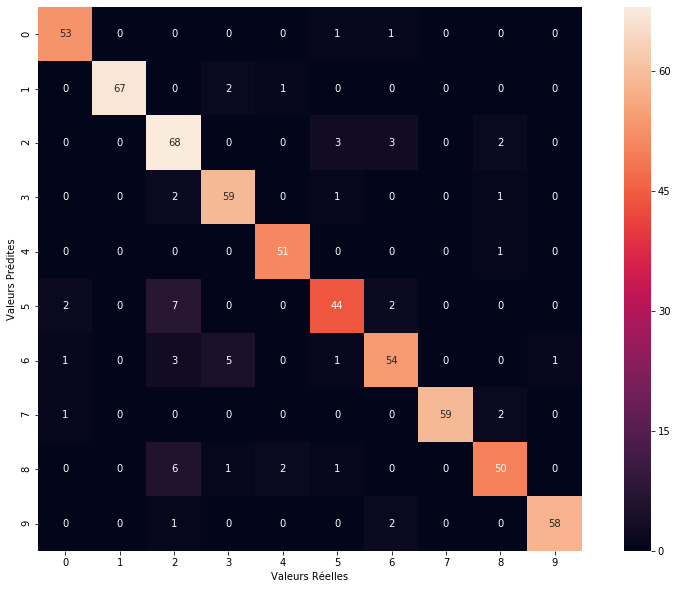

In [86]:
%matplotlib inline

plt.figure(figsize=(15,10))

ax = sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f', xticklabels=True)

ax.set_ylabel('Valeurs Prédites')
ax.set_xlabel('Valeurs Réelles')

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [87]:
accuracy = accuracy_score(y_valid_flat, Y_predict)
print(accuracy)

0.9095315024232633


In [88]:
predict_ok = []
true = 0
false = 0
for i in range(len(Y_predict)):
    if Y_predict[i] == y_valid_flat[i]:
        p = True 
        true += 1    
    else:
        p = False
        false += 1
    predict_ok.append(p)
                
predict_ok
print('Nombres de prédictions Valide :',true)
print('Nombres de mauvaise prédictions :',false)

Nombres de prédictions Valide : 563
Nombres de mauvaise prédictions : 56


In [41]:
df = pd.DataFrame(conf_mat, range(10),
                  range(10))
df.rename_axis('Prédites').rename_axis('Réelles', axis='columns')

Réelles,0,1,2,3,4,5,6,7,8,9
Prédites,,,,,,,,,,
0,51,0,0,0,1,2,0,0,0,1
1,0,66,0,1,2,1,0,0,0,0
2,0,0,67,2,1,5,1,0,0,0
3,0,0,2,55,0,0,1,0,5,0
4,0,0,2,0,49,0,0,0,1,0
5,1,0,7,0,0,47,0,0,0,0
6,2,0,5,7,0,4,46,0,0,1
7,1,0,0,0,0,0,0,60,1,0
8,0,0,2,5,4,0,1,0,48,0


In [89]:
comp = pd.DataFrame(y_valid_flat, Y_predict)
comp.head(50)


,0
3,6
9,9
3,3
9,9
0,0
5,5
8,8
2,2
5,5
9,9


In [ ]:
y_valid_flat[0]

In [ ]:
X_valid = X_valid.reshape((619, 64, 64))